# Predict Discount Based on Age

In [1]:
from random import randrange, choice
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split


## Create Data

In [2]:
sample_size =25000
data_file = f'../data/discount_data_{sample_size}.xlsx'

business_list = ['bar', 'restaurant', 'hotel', 'pharmacy', 'spa', 'airline']


def calculate_discount(age, sex, business_type, is_resident):
    business_discounts = dict()
    business_discounts['restaurant'] = 0.2
    business_discounts['pharmacy'] = 0.2
    business_discounts['hotel'] = 0.25
    
    if sex == 'M' and age >= 64 and is_resident:
        return business_discounts.get(business_type, 0.0)
    elif sex == 'F' and age >= 57 and is_resident:
        return business_discounts.get(business_type, 0.0)
    else:
        return 0.0
    
def build_dataframe(samples):

    data = dict()
    data['sex'] = list()
    data['age'] = list()
    data['business_type'] = list()
    data['discount'] = list()
    data['is_resident'] = list()
    for i in range(samples):
        age = randrange(18, 95, 1)
        sex = choice(['M', 'F'])
        business_type = choice(business_list)
        is_resident =  choice([True, False])
        discount = calculate_discount(age, sex, business_type, is_resident)
        #print(f'{sex} age {age} for {business_type}')
        data['sex'].append(sex)
        data['age'].append(age)
        data['business_type'].append(business_type)
        data['discount'].append(discount)
        data['is_resident'].append(is_resident)

        df = pd.DataFrame.from_dict(data)
    return df
    


In [3]:
if os.path.exists(data_file):
    df = pd.read_excel(data_file)
    print(f'Loaded from {data_file}')
else:
    df = build_dataframe(sample_size)
    df.to_excel(data_file, index=False)
    print(f'Saved to {data_file}')

Loaded from ../data/discount_data_25000.xlsx


In [4]:
print(f'Shape: {df.shape}')
df.head()

Shape: (25000, 5)


,sex,age,business_type,discount,is_resident
0,F,43,airline,0.0,True
1,M,89,spa,0.0,True
2,M,31,pharmacy,0.0,False
3,M,50,airline,0.0,True
4,F,61,airline,0.0,True


## Cleanup


### Separate dependent and independent variables

In [5]:
discounts = df['discount'].copy()
df.drop(columns=['discount',], inplace=True)

print(f'discount shape: {discounts.shape}')

df.head()

discount shape: (25000,)


,sex,age,business_type,is_resident
0,F,43,airline,True
1,M,89,spa,True
2,M,31,pharmacy,False
3,M,50,airline,True
4,F,61,airline,True


### Hot One Encode

In [6]:
df = pd.get_dummies(df, columns=['sex', 'business_type'])


In [7]:


df['is_resident'].replace({False: 0, True: 1}, inplace=True)

### Scaling age

In [8]:
scaler = MinMaxScaler()
df['age'] = scaler.fit_transform(df['age'].values.reshape(-1, 1))


In [9]:
print(f'Shape: {df.shape}')
df.head()

Shape: (25000, 10)


,age,is_resident,sex_F,sex_M,business_type_airline,business_type_bar,business_type_hotel,business_type_pharmacy,business_type_restaurant,business_type_spa
0,0.328947,1,1,0,1,0,0,0,0,0
1,0.934211,1,0,1,0,0,0,0,0,1
2,0.171053,0,0,1,0,0,0,1,0,0
3,0.421053,1,0,1,1,0,0,0,0,0
4,0.565789,1,1,0,1,0,0,0,0,0


### Split Training and Test Data

In [47]:

X_train, X_test, y_train, y_test = train_test_split(df.values, discounts.values,
                                                    test_size=0.2, random_state=25)

print('Train', X_train.shape, y_train.shape)
print('Test',X_test.shape, y_test.shape)

Train (20000, 10) (20000,)
Test (5000, 10) (5000,)


## Basic Neuronal Network


https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33

In [48]:
learning_rate = 0.001

#checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
#checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
#callbacks_list = [checkpoint]

In [49]:
model = tf.keras.models.Sequential()
print(X_train.shape[1])
model.add(Dense(X_train.shape[1], kernel_initializer='normal',input_dim = X_train.shape[1],
                activation='relu'))

model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
model.add(Dense(1, kernel_initializer='normal',activation='linear'))


10


In [50]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss='mean_absolute_error',
    metrics=['mean_absolute_error']
)

In [51]:
history = model.fit(X_train, y_train, epochs=100, 
                    batch_size=32, validation_split = 0.2,
                   verbose=False)
                    #callbacks=callbacks_list))

In [52]:
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


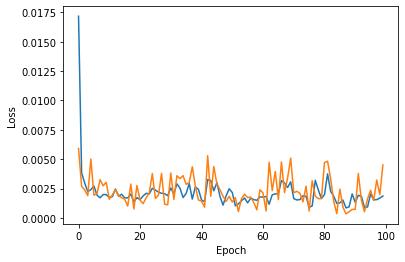

In [53]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

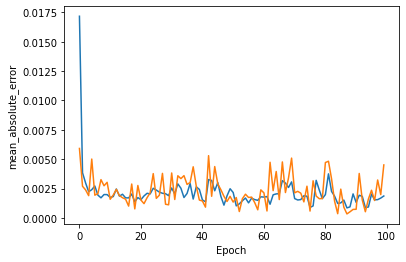

In [54]:
plt.xlabel('Epoch')
plt.ylabel('mean_absolute_error')
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.show()

In [57]:
#df_values = df.values
#disc_value = discounts.values
#print(y_test)
c = 1
i = 0
for discount in y_test:
    if discount > 0.0:
        print(i, discount)
        c += 1
    if c == 10:
        break
    i += 1
        
print('>>',y_test[51])

3 0.2
5 0.2
6 0.2
7 0.25
22 0.25
25 0.2
42 0.25
45 0.25
51 0.25
>> 0.25


In [61]:
t = 51
print(X_test[t])
print(y_test[t])

[0.86842105 1.         0.         1.         0.         0.
 1.         0.         0.         0.        ]
0.25


In [64]:
pred = model.predict(X_test) #.reshape(10,1))
#print(type(pred))
print(f'Estimated discount {pred[t]}')

Estimated discount [0.25104082]


In [65]:


print(f'Estimated discount {pred[3]}')

Estimated discount [0.19996476]


In [66]:

print(f'Estimated discount {pred[0]}')

Estimated discount [0.00035593]
